In [2]:
!pip install ffmpeg-python
import pandas as pd
import numpy as np
import tensorflow as tf
import os,time,librosa,warnings,glob
import regex as re
from sklearn.metrics import confusion_matrix,classification_report
import librosa.display
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Dense,Input,Add,Flatten,Dropout,Activation,AveragePooling1D,Conv1D
from keras.models import Model,Sequential,load_model
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from base64 import b64decode
from IPython.display import Audio,HTML
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg
warnings.filterwarnings("ignore")

In [3]:
mylist= os.listdir('C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/')

In [4]:
mylist

['ASVP-ESD-Update',
 'ASVP-ESD-Update.zip',
 'Audio_features_All_pr.csv',
 'CREMA-D',
 'EmoDB',
 'Emotion Speech Dataset',
 'IEMOCAP',
 'RAVEDESS',
 'SAVEE',
 'TESS',
 '__MACOSX']

In [57]:
#decorator function for calculating the total time reqired to execute various function
def calc_time(func):
  def inner(*args, **kwargs):
    st = time.time()
    result = func(*args,**kwargs)
    end = time.time()-st
    print("Total time required: {:.3f} ms".format(end * 1000))
    return result
  return inner

def emodb_data():
  emodb="C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/EmoDB"

    # Mapping from emotion code to emotion label
  emodb_emotions = {
        'W': 'anger',
        'L': 'boredom',
        'E': 'disgust',
        'A': 'fear',
        'F': 'happy',
        'N': 'neutral',
        'T': 'sad'
    }
  emodb_emotionslist = []
  emodb_path = []

    # Get all CREMA files in the directory
  emo_files = os.listdir(emodb)

  for file in emo_files:
        # Extract the emotion code from the file name (4th character in the name)
      emotion_code = file[5]

      emotion = emodb_emotions.get(emotion_code)

      if emotion:  # Proceed only if emotion code is valid
          emodb_emotionslist.append(emotion)
          emodb_path.append(os.path.join(emodb, file))

    # Convert to DataFrame
  df_emodb = pd.DataFrame({
        "AudioPath": emodb_path,
        "Label": emodb_emotionslist
    })

  print("Length of EMOD dataset:", len(df_emodb))

  return df_emodb



#function for getting ravdess dataset details and labeling
def ravdess_data():
  #directory of the audio dataset
  ravdess = "C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/RAVEDESS/"
  #label ravdess data
  emotion_ravdess = {'01':'neutral','02':'calm','03':'happy','04':'sad','05':'angry','06':'fearful','07':'disgust','08':'surprised'}
  #list to store ravdess emotion
  ravdess_emotion = []
  #list to store ravdess audio path
  ravdess_path = []
  #get subfolders from the path
  ravdess_folder = os.listdir(ravdess)
  for i in ravdess_folder:
    inner_files = os.listdir(ravdess+i+'/')

    for j in inner_files:
      #get the split part which contains the emotion information then append it into lists
      emotion = j.split('-')[2]
      ravdess_path.append(ravdess+i+'/'+j)
      ravdess_emotion.append(emotion_ravdess[emotion])

  #convert to dataframe
  df_ravdess = pd.DataFrame([ravdess_path,ravdess_emotion]).T
  df_ravdess.columns = ["AudioPath","Label"]
  print("length of ravdess dataset",len(df_ravdess))

  return df_ravdess







#function for getting crema dataset details and labeling
def crema_data():
  #directory of the audio dataset
  crema = "C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/CREMA-D/"
  #label ravdess data
  emotion_crema = {'SAD':'sad','ANG':'angry','DIS':'disgust','FEA':'fear','HAP':'happy','NEU':'neutral'}
  #list to store crema emotion
  crema_emotion = []
  #list to store crema audio path
  crema_path = []
  #get crema files in directory
  crema_files = os.listdir(crema)
  for i in crema_files:
    emotion = i.split('_')[2]
    crema_emotion.append(emotion_crema[emotion])
    crema_path.append(crema+i)

  #convert to dataframe
  df_crema = pd.DataFrame([crema_path,crema_emotion]).T
  df_crema.columns = ["AudioPath","Label"]
  print("length of crema dataset",len(df_crema))
  return df_crema


#function for getting tess dataset and labeling
def tess_data():
  #directory of the audio dataset
  tess = "C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/TESS/TESS Toronto emotional speech set data/"
  tess_emotion = []
  tess_path = []
  tess_folder = os.listdir(tess)
  for i in tess_folder:

    emotion = i.split('_',1)[1]
    inner_files = os.listdir(tess+i+'/')
    for j in inner_files:
      tess_path.append(tess+i+'/'+j)
      tess_emotion.append(emotion)

  #convert to dataframe
  df_tess = pd.DataFrame([tess_path,tess_emotion]).T
  df_tess.columns = ["AudioPath","Label"]
  print("length of tess dataset",len(df_tess))

  return df_tess


def saveee_data():
    # Directory of the audio dataset
    savee = "C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/SAVEE/AudioData/"
    emotion_savee = {
        'a': 'anger',
        'd': 'disgust',
        'f': 'fear',
        'h': 'happiness',
        'n': 'neutral',
        'sa': 'sadness',
        'su': 'surprise'
    }
    savee_emotion = []
    savee_path = []

    # Iterate over subfolders (DC, JE, JK, KL)
    for subfolder in os.listdir(savee):
        subfolder_path = os.path.join(savee, subfolder)
        if os.path.isdir(subfolder_path):
            # Iterate over files in the subfolder
            for file in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file)

                # Extract the emotion code and match it with the dictionary
                file_stem = file.split('.')[0]
                match = re.match(r"([a-z]+)(\d+)", file_stem)
                if match:
                    emotion_code = match.group(1)
                    if emotion_code in emotion_savee:
                        savee_emotion.append(emotion_savee[emotion_code])
                        savee_path.append(file_path)
                else:
                    print(f"No match found for file: {file_stem}")  # Debugging output
    # Convert to DataFrame
    df_savee = pd.DataFrame({
        "AudioPath": savee_path,
        "Label": savee_emotion
    })
    print("Length of SAVE dataset:", len(df_savee))
    return df_savee

@calc_time
def fetch_data():
  #get ravdess data
  #df_ravdess = ravdess_data()
  #get crema data
  #df_crema = crema_data()
  #get tess data
  #df_tess = tess_data()
  #get savee data
  #df_savee = saveee_data()
  #get emodb data
  df_emodb = emodb_data()
  #combine all four dataset into one single dataset and create a dataframe
  #frames = [df_ravdess,df_crema,df_tess,df_savee, df_emodb]
  frames = [df_emodb]
  final_combined = pd.concat(frames)
  final_combined.reset_index(drop=True,inplace=True)
  #save the information of datasets with their path and labels into a csv file
  final_combined.to_csv("C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/preprocesseddata.csv",index=False,header=True)
  print("Total length of the dataset is {}".format(len(final_combined)))
  return final_combined

#below are four data agumentation functions for noise, stretch, shift, pitch
#function to add noise to audio
def noise(data):
  noise_amp = 0.035* np.random.uniform()*np.amax(data)
  data = data + noise_amp*np.random.normal(size=data.shape[0])
  return data

#fuction to strech audio
def stretch(data):
    # You can specify the stretch rate inside the function if needed
    rate = 0.8  # Example stretch rate, adjust as needed
    return librosa.effects.time_stretch(data, rate)


#fucntion to shift audio range
def shift(data):
  shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
  return np.roll(data, shift_range)

#function to change pitch
def pitch(data, sampling_rate, pitch_factor=0.7):
  return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

#fuction to extract audio features from the audio files given the information of their path
#path and label information comes from fetch_data fucntion
#also file preprocesseddata.csv stores the information of paths of audio files their label information
#the print statements are commented these statements were used to see the number of features returned as output
def extract_features(data,sample_rate):

  #zero crossing rate
  result = np.array([])
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result = np.hstack((result, zcr))
  #print('zcr',result.shape)

  #chroma shift
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft))
  #print('chroma',result.shape)

  #mfcc
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
  #print('mfcc',result.shape)

  #rmse
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
  #print('rmse',result.shape)

  #melspectogram
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  #print('mel',result.shape)

  #rollof
  rollof = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, rollof))
  #print('rollof',result.shape)

  #centroids
  centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, centroid))
  #print('centroids',result.shape)

  #contrast
  contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
  #print('contrast',result.shape)

  #bandwidth
  bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, bandwidth))
  #print('bandwidth',result.shape)

  #tonnetz
  tonnetz = np.mean(librosa.feature.tonnetz(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, tonnetz))
  #print('tonnetz',result.shape)

  return result

#function is used to get all augmented plus original features for given audio file
def get_features(path):
    # set the duration and offset
    # librosa.load takes audio file converts to array and returns array of audio file with its sampling rate
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # get audio features without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # get audio features with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # get audio features with stretching and pitching
    data_stretch = librosa.effects.time_stretch(data, rate=0.8)  # Adjust rate as needed
    res3 = extract_features(data_stretch, sample_rate)
    result = np.vstack((result, res3))

    return result




In [58]:
#fucntion one by one takes aduio files from the path extracts features
#extracted audio features along with their label information are stored in a csv file
@calc_time
def Audio_features_extract():
  #this function is used to fetch the data from all the four datasets
  df = fetch_data()
  #count is used to keep a check of number of files processed
  count = 0
  #list to store audio features and their label information
  X_data, Y_label = [], []
  #zip audio path and label information and then iterate over them
  for path, emotion in zip(df["AudioPath"], df["Label"]):
    print("Number of files processed ",count)
    #get the features
    #for one audio file it get three sets of features
    #original features, features with noise(agumentation) and feature with change in stretch and pitch
    #so one audio file generates three output and the label is same for all the outputs
    feature = get_features(path)
    for ele in feature:
      X_data.append(ele)
      Y_label.append(emotion)
    count+=1
  #create a dataframe of aduio features
  Features = pd.DataFrame(X_data)
  #add label information
  Features['Label'] = Y_label
  #store the extracted features in a csv file
  Features.to_csv('C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/EMODB_Audio_features.csv',index=False)

#this is just one time process so call this function once only to get the features
#once the features are extracted then these features are used for making model
Audio_features_extract()

Length of EMOD dataset: 535
Total length of the dataset is 535
Total time required: 88.986 ms
Number of files processed  0
Number of files processed  1
Number of files processed  2
Number of files processed  3
Number of files processed  4
Number of files processed  5
Number of files processed  6
Number of files processed  7
Number of files processed  8
Number of files processed  9
Number of files processed  10
Number of files processed  11
Number of files processed  12
Number of files processed  13
Number of files processed  14
Number of files processed  15
Number of files processed  16
Number of files processed  17
Number of files processed  18
Number of files processed  19
Number of files processed  20
Number of files processed  21
Number of files processed  22
Number of files processed  23
Number of files processed  24
Number of files processed  25
Number of files processed  26
Number of files processed  27
Number of files processed  28
Number of files processed  29
Number of files 

Number of files processed  265
Number of files processed  266
Number of files processed  267
Number of files processed  268
Number of files processed  269
Number of files processed  270
Number of files processed  271
Number of files processed  272
Number of files processed  273
Number of files processed  274
Number of files processed  275
Number of files processed  276
Number of files processed  277
Number of files processed  278
Number of files processed  279
Number of files processed  280
Number of files processed  281
Number of files processed  282
Number of files processed  283
Number of files processed  284
Number of files processed  285
Number of files processed  286
Number of files processed  287
Number of files processed  288
Number of files processed  289
Number of files processed  290
Number of files processed  291
Number of files processed  292
Number of files processed  293
Number of files processed  294
Number of files processed  295
Number of files processed  296
Number o

Number of files processed  530
Number of files processed  531
Number of files processed  532
Number of files processed  533
Number of files processed  534
Total time required: 608218.525 ms


In [82]:
df = pd.read_csv('C:/Users/KRISHNA/Desktop/SHWETA/SpringSummer 2024/Software Engineering/Project/Datasets/RAVEDESS_Audio_features.csv')  

In [83]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,Label
0,0.321275,0.729664,0.750032,0.730624,0.735275,0.713529,0.660531,0.684966,0.733049,0.753971,...,17.976807,46.214819,2457.919172,-0.039651,0.017605,-0.038968,-0.058740,0.016288,0.010934,neutral
1,0.299678,0.765438,0.800920,0.792474,0.795014,0.801043,0.706200,0.663548,0.712517,0.740466,...,15.173382,13.664522,2982.497924,-0.005144,0.001970,-0.050740,-0.004590,0.000940,0.004312,neutral
2,0.173025,0.674528,0.752073,0.725325,0.729231,0.728289,0.665119,0.660569,0.720074,0.758500,...,19.653582,46.469504,2437.258812,-0.022829,0.015879,-0.043919,-0.055273,0.019473,0.000833,neutral
3,0.293566,0.673896,0.722096,0.723508,0.682302,0.680533,0.675352,0.628977,0.679179,0.707283,...,17.866520,45.765516,2464.897836,-0.068961,0.034252,-0.058583,-0.055763,0.014269,-0.005250,neutral
4,0.316542,0.786291,0.805342,0.794776,0.795285,0.787402,0.682009,0.647502,0.702620,0.739819,...,14.456018,13.492789,3181.664460,-0.016667,0.006654,-0.061299,0.001615,0.001593,-0.006504,neutral


In [84]:
print("\nUnique count of labels or emotions\n",df["Label"].value_counts())


Unique count of labels or emotions
 Label
calm         576
happy        576
sad          576
angry        576
fearful      576
disgust      576
surprised    576
neutral      288
Name: count, dtype: int64


In [65]:
  #df["Label"] = df["Label"].str.replace("sadness", "sad", case = True)
  df["Label"] = df["Label"].str.replace("happiness", "happy", case = True)
  df["Label"] = df["Label"].str.replace("Fear", "fear", case = True)
  df["Label"] = df["Label"].str.replace("Sad", "sad", case = True)
  df["Label"] = df["Label"].str.replace("Pleasant_surprise", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("pleasant_surprised", "surprise", case = True)
  df["Label"] = df["Label"].str.replace("surprised", "surprise", case = True)
  #df["Label"] = df["Label"].str.replace("fearful", "fear", case = True)
  df["Label"] = df["Label"].str.replace("anger", "angry", case = True)
  #drop labels surprized and clam
  #these label dosent contain sufficent amount of data and can lead to missclassification
  print("\nUnique count of labels or emotions\n",df["Label"].value_counts())
  #drop labels or emotions which can lead to misclassifications
  df.drop((np.where(df['Label'].isin(["surprise"]))[0]), inplace = True)
  print("\nUnique count of labels or emotions after dropping selected labels\n",df["Label"].value_counts())
  print("\nlength of the total data is {}".format(len(df)))


Unique count of labels or emotions
 Label
angry      381
boredom    243
neutral    237
happy      213
fear       207
sad        186
disgust    138
Name: count, dtype: int64

Unique count of labels or emotions after dropping selected labels
 Label
angry      381
boredom    243
neutral    237
happy      213
fear       207
sad        186
disgust    138
Name: count, dtype: int64

length of the total data is 1605


In [85]:
  from sklearn.preprocessing import StandardScaler, LabelEncoder
  data=df[df.columns[0:-1]].values
  #perform one hot encoding on labels
  encoder = OneHotEncoder()
  label_encoder = LabelEncoder()
  #fetch the last column of labels and perform one hot encoding on them
  label=df["Label"].values
  label = label_encoder.fit_transform(label)
  #min max scaler is used to normalize the data
  scaler = MinMaxScaler()
  data=scaler.fit_transform(data)
  #split the dataframe into train and test 80% train, 10% validation and 10% test datasets
  x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.20, random_state=42,shuffle=True)

# SVM with RBF kernel

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

# Perform GridSearchCV to find the best hyperparameters
#grid_search = GridSearchCV(SVC(), param_grid)
#grid_search.fit(x_train, y_train)

# Get the best model
#best_svm = grid_search.best_estimator_

#best_svm=SVC(kernel="rbf",gamma=1,C=100)
best_svm=SVC(kernel="rbf",gamma=1,C=10)
best_svm.fit(x_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

#print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8078703703703703
Classification Report:
              precision    recall  f1-score   support

       angry       0.87      0.90      0.88       114
        calm       0.78      0.86      0.82        99
     disgust       0.79      0.81      0.80       128
     fearful       0.82      0.82      0.82       119
       happy       0.81      0.75      0.78       111
     neutral       0.72      0.84      0.78        58
         sad       0.80      0.66      0.73       116
   surprised       0.84      0.84      0.84       119

    accuracy                           0.81       864
   macro avg       0.80      0.81      0.81       864
weighted avg       0.81      0.81      0.81       864



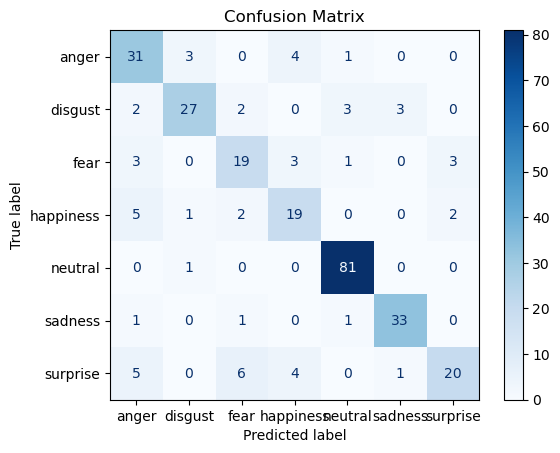

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [79]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators=150, random_state=42)
random_forest.fit(x_train, y_train)

# Predict on the test set
y_pred = random_forest.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.6341244961934617
Classification Report:
              precision    recall  f1-score   support

       angry       0.75      0.79      0.77       787
     disgust       0.61      0.48      0.54       777
        fear       0.80      0.47      0.59       734
       happy       0.57      0.64      0.61       709
     neutral       0.57      0.66      0.61       674
         sad       0.58      0.75      0.66       785

    accuracy                           0.63      4466
   macro avg       0.65      0.63      0.63      4466
weighted avg       0.65      0.63      0.63      4466



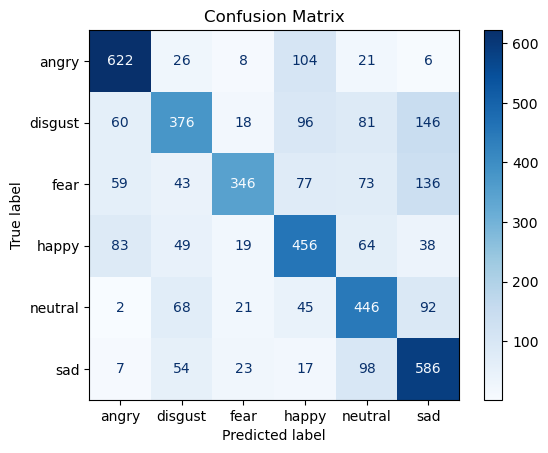

In [80]:
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

gradient_booster = GradientBoostingClassifier(learning_rate=0.1)

gradient_booster.fit(x_train,y_train)
y_pred = gradient_booster.predict(x_test)

print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# KNN

In [43]:
from sklearn.neighbors import KNeighborsClassifier
k = 5  # Choose an appropriate k
knn = KNeighborsClassifier(n_neighbors=k)

# Train the classifier
knn.fit(x_train, y_train)

# Predict on the test set
y_pred = knn.predict(x_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.99
              precision    recall  f1-score   support

       angry       0.99      0.99      0.99       258
     disgust       0.99      0.99      0.99       235
        fear       0.99      1.00      1.00       250
       happy       0.99      0.99      0.99       228
     neutral       1.00      1.00      1.00       251
         sad       0.99      0.99      0.99       218

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440



In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Points to be noted: Random Forest was effectively able to classify angry and sad emotions whereas KNN was able to classify the remaining 4. So combining predictionsof both of these can be helpful in classifying all of them.

# Random Forest and SVM with Bagging approach

In [ ]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
# Define the base models
svm=SVC(kernel="rbf",gamma=1,C=10)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Define the bagging classifier for SVM
bagging_svm = BaggingClassifier(estimator=svm,n_estimators=10, random_state=42)

# Define the bagging classifier for Random Forest
bagging_rf = BaggingClassifier(estimator=random_forest, n_estimators=10, random_state=42)

# Train the bagging models
bagging_svm.fit(x_train, y_train)
bagging_rf.fit(x_train, y_train)

# Predict on the test set using both models
y_pred_svm = bagging_svm.predict(x_test)
y_pred_rf = bagging_rf.predict(x_test)

# Combine predictions to create meta-features
meta_features = np.column_stack((y_pred_svm, y_pred_rf))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# Define meta-learner (can be any classifier)

   # "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    # "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
    # SVM: SVC(kernel='linear', random_state=42) 

meta_learner =  KNeighborsClassifier(n_neighbors=100)
# Train meta-learner on meta-features and true labels
meta_learner.fit(meta_features, y_test)

# Use the trained meta-learner to make predictions on new data (test set)
# Assuming X_test is available
y_pred_stacking = meta_learner.predict(meta_features)

# Evaluate stacking model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Accuracy (Stacking): {accuracy_stacking}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
#RANDOM FOREST AS THE META-LEARNER
cm = confusion_matrix(y_test, y_pred_stacking)
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Random Forest and SVM with Boosting Approach

Accuracy (Boosted SVM and RF): 0.8460648148148148
              precision    recall  f1-score   support

       angry       0.87      0.91      0.89       114
        calm       0.79      0.94      0.86        99
     disgust       0.84      0.84      0.84       128
     fearful       0.88      0.83      0.86       119
       happy       0.81      0.84      0.82       111
     neutral       0.83      0.78      0.80        58
         sad       0.83      0.73      0.78       116
   surprised       0.90      0.88      0.89       119

    accuracy                           0.85       864
   macro avg       0.85      0.84      0.84       864
weighted avg       0.85      0.85      0.85       864



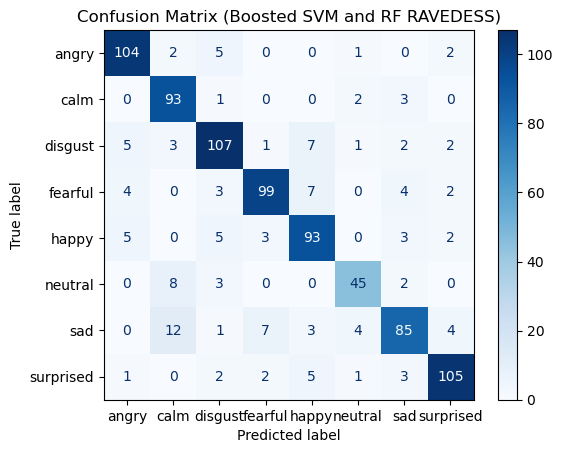

In [87]:
# Define the base models
svm=SVC(probability=True,kernel="rbf",gamma=1,C=10)
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 1: Train the RF model on the original dataset
random_forest.fit(x_train, y_train)

# Step 2: Evaluate the RF model and get the misclassified samples
y_pred_rf = random_forest.predict(x_train)
misclassified_samples = (y_pred_rf!= y_train)

# Step 3: Increase weights of misclassified samples (custom weighting scheme)
sample_weights = np.ones(len(y_train))
sample_weights[misclassified_samples] *= 2  # Double the weights of misclassified samples

# Step 4: Train the SVM model on the weighted samples
svm.fit(x_train, y_train, sample_weight=sample_weights)

# Step 5: Get predictions from both models on the test set
svm_probs = svm.predict_proba(x_test)
rf_probs = random_forest.predict_proba(x_test)

# Step 6: Combine the probabilities using a weighted average (equal weights for simplicity)
combined_probs = (svm_probs + rf_probs) / 2

# Step 7: Convert combined probabilities to final predictions
y_pred_combined = np.argmax(combined_probs, axis=1)

# Evaluate the combined model
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy (Boosted SVM and RF): {accuracy_combined}")
print(classification_report(y_test, y_pred_combined, target_names=label_encoder.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Boosted SVM and RF RAVEDESS)')
plt.show()

In [ ]:
meta_features = np.hstack((svm_probs + rf_probs))

In [ ]:
meta_features[0]

In [ ]:
len(y_test)

In [ ]:
# Combine predictions to create meta-features
meta_features = np.hstack((svm_probs + rf_probs))
meta_learner =  RandomForestClassifier(n_estimators=100, random_state=42) 
# Train meta-learner on meta-features and true labels
meta_learner.fit(meta_features, y_test)

# Use the trained meta-learner to make predictions on new data (test set)
# Assuming X_test is available
y_pred_stacking = meta_learner.predict(meta_features)

# Evaluate stacking model
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Accuracy (Stacking): {accuracy_stacking}")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_combined)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Boosted SVM and RF)')
plt.show()